# Adversarial Attacks on Traffic Models
*by Gene Yang*

Our goals are to **identify vulnerabilities in models and try exploiting them** <br>
Most models published focus on their efficiencies but not many look at their own vulnerabilities. They aim for better performance with less concern for how susceptible they are to attack. By highlighting these vulnerabilities to data poisoning attacks, we will **promote better defense methods** among future models.

- I learned the basics of adversarial machine learning through Vorobeychik & Kantarcioglu's seminal text, as well as even more modern work by Jagielski, Biggio, etc.
- I used a colormap to vizualize the effectiveness of data poisoning in collaboration with Feilong's work in calculating change in estimated queue length.
- Implemented a gradient-based solution to poison SVM and visualize its effectiveness based on Jagielski's work

# Readings consulted:

> Vorobeychik, Y. and Kantarcioglu, M. Adversarial Machine Learning. Springer International Publishing. https://doi.org/10.1007/978-3-031-01580-9, 2018.

> Jagielski, M., Oprea, A., Biggio, B., Liu, C., Nita-Rotaru, C., & Li, B. Manipulating Machine Learning: Poisoning Attacks and Countermeasures for Regression Learning (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1804.00308, 2018.


> Scott Alfeld, Xiaojin Zhu, and Paul Barford. Data poisoning attacks against autoregressive models.
In *Thirtieth AAAI Conference on Artificial Intelligence*, 2016.

> M. B. Sinai, N. Partush, S. Yadid, and E. Yahav. Exploiting social navigation. CoRR,
abs/1410.0151, 2014.

> Ban, X. J., & Sun, Z. Vehicle classification using mobile sensors, 2013.


> Biggio, B., Nelson, B., & Laskov, P. Poisoning Attacks against Support Vector Machines (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1206.6389, 2012.


Next, I created a formula-based visualization of the effectiveness of data poisoning with Feilong's work on attacking TSEP models. 

# My Cycle Breaking Poisoning

This takes the formula based cycle breaking, and then determines the effectiveness of a given perturbation by calculating the partial derivatives with the implicit function theorem according to this formula:
<br>
$$\begin{align}
\partial_x &= -\frac{b+a\cdot\mu}{R\cdot a^2\cdot(\Sigma-\mu^2)}\cdot(a\cdot(x'-\mu)+b+a\cdot x'-y')-\frac{1}{R}\\
\partial_y &= \frac{b+a\cdot\mu}{R\cdot a^2\cdot(\Sigma-\mu^2)}\cdot(x'-\mu)-\frac{1}{R\cdot a}\\
|\partial| &= \sqrt{\partial_x^2+\partial_y^2}
\end{align}$$
<br>
where x' and y' are the values of the added point, $\mu$ is the mean of the data equal to $\frac{\Sigma}{R}$, and ax+b is the current best fit line.
<br>

Then the code visualizes the perturbation to the line-fitting algorithm built in the IDE Algorithm for further analysis. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd

cbvtestingdataset = pd.read_csv("/Users/geneyang/Documents/Arterial Travel Time/CBV.csv")
cbvtestingdataset

,dT,dD,CBV?
0,6,-4,-1
1,4,-2,-1
2,4,-1,-1
3,4,-2,-1
4,4,-2,-1
...,...,...,...
134,39,-9,-1
135,31,-27,-1
136,3,-1,-1
137,5,1,-1


To run: 
First go to cycles = [cycles[7]] and change it to any of the cycles to test. So far, poisoning visualization only works on cycles that can be approximated with one line, so 7 is a good example.
Then change the values of addx and addy
Using the calculations in the presentation, the program will show a graph with a circle centered at x=(addx, addy) with radius proportional to the magnitude of the partial of q with respect to x. Another graph with just the cycle being investigated, as well as its mean and the point x will be shown too. Note that this differs in approach from the github project, which does complicated linear algebra and actually simulates running the machine learning with the poisoned data added.
Simulating adding the point and then re-calculating the fit lines is another possibility for future work, as well as making the program work for two-line fits (I wonder how to theoretically do that, since it might alter both lines. We would then need another metric, perhaps a sum of squares of how much each line changes, and then will have to see how a single point alters both of them. This seems interesting but perhaps too unrelated).

Now, the following code calculates the magnitude of the change to the queue length estimation when a point addx, addy is added. Then it visualizes it using an orange circle scaled to that size.

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 30 13:56:22 2021

@author: geneyang
"""
#%% import required packages
import pandas as pd
import numpy as np
from scipy import optimize
import math
import statistics
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import fsolve
from sklearn.metrics import r2_score
from sklearn import svm
from statistics import mean
from matplotlib.patches import Ellipse

In [ ]:
#%% import the data and format it
attdata = pd.read_csv("/Users/geneyang/Documents/Arterial Travel Time/arterial travel times.csv")
attdata = attdata.drop('End time (sec)',1)
attdata = attdata.drop('v_id',1)
attdata.dtypes
attdata = attdata.sort_values(['Start time (sec)'])

cbvtestingdataset = pd.read_csv("/Users/geneyang/Documents/Arterial Travel Time/CBV.csv")

In [ ]:
#%% scale data
t_start = attdata['Start time (sec)'].min()
attdata['Start time (sec)'] = attdata['Start time (sec)']-t_start
attdata.reset_index(drop=True, inplace=True)
maxdiff = attdata['Travel time (sec)'].max()

In [ ]:
#%% plot the data
startTime = attdata['Start time (sec)'].to_list()
travelTime = attdata['Travel time (sec)'].to_list()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(startTime, travelTime,'-*')
# attdata.plot(x='Start time (sec)', y='Travel time (sec)')

In [ ]:
#%% break the data into cycles
threshold_1 = 10 # to break the data and find circles
threshold_2 = 100 #unused

cycles = [] #index of new cycles, each cycle is a pair of (start, end) inclusive
startindex = 0
endindex = 0
for i in range(1, len(travelTime)): # indexes of cycle borders
    if travelTime[i] - travelTime[i-1] > threshold_1:
        # print(travelTime[i], " jumps from ", travelTime[i-1], ' by ', travelTime[i] - travelTime[i-1])
        endindex = i - 1
        if endindex - startindex >= 2:  # we need at least 2 points in one cycle to fit a line
            cycles.append((startindex, endindex))
        startindex = i
cycles.append((startindex, len(travelTime)-1)) # closing off the last cycle

## create a stack, so that we can do "last in and first out" operation; why: I will later add new circle dynamically and process the newly added circle
cyclesASstack = [cycles[i] for i in range(len(cycles)-1, -1, -1)]
cycles = cyclesASstack

# print(cycles)

In [ ]:
#%% cycle svm fitting
#according to the paper, each point has x value vehicle's delay - previous delay, y is arrival time - previous arrival time

dT = cbvtestingdataset['dT'].to_numpy()
dD = cbvtestingdataset['dD'].to_numpy()
training_X = np.column_stack((dT,dD))

training_Y = cbvtestingdataset['CBV?'].to_numpy()

clf = svm.SVC(kernel='linear', C=1.0)

clf.fit(training_X, training_Y)

w=clf.coef_[0]

a = -w[0]/w[1]

XX = np.linspace(0,10)

yy = a * XX - clf.intercept_[0] / w[1]

In [ ]:
#%% define function fitting two lines
def fit_2line(para):  # x0 is a_1, x1 is b_1, x2 is a_2, x3 is b_2, and x4 is m
    m = math.floor(para[4])
    if m < 2 or m > R - 1:
        return 1000000000000  # large enough that it will never be the min
    sum1 = ((para[0] * t[:m] + para[1] - d[:m]) ** 2).sum()
    sum2 = ((para[2] * t[m:] + para[3] - d[m:]) ** 2).sum()
    return sum1 + sum2


def Fcontr(para):  # x0 is a_1, x1 is b_1, x2 is a_2, x3 is b_2, and x4 is m
    m = math.floor(para[4])
    boundINgroup = (1 - theta) * t[m - 1] + theta * t[m]
    return para[0] * boundINgroup + para[1] - (para[2] * boundINgroup + para[3])


constr = {'type': 'eq', 'fun': Fcontr}

[(82, 84)]
b/a is -1050.2794376098418
1 line was better
Given the values a= -0.762734584450402, b= 801.0844504021446, mu= 981, sigma= 963752.3333333333
The variance is 1391.3333333332557
For the cycle (82,84) , the magnitude of the partial for adding the point 500, 60 is: 19.006639788930283


Text(0.5, 0, 'Start time (scaled; sec)')

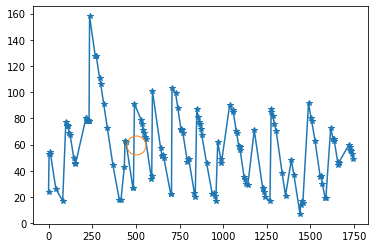

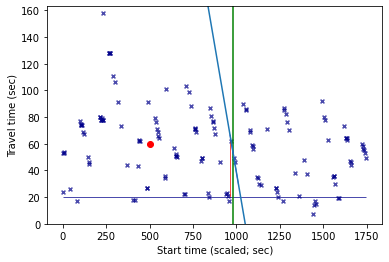

In [10]:
#%% main function for fitting all circle and visualization

plt.figure()

ASPECT_RATIO = 8 #roughly

addx = 500
addy = 60

plt.plot(addx, addy, '-ro')

plt.scatter(startTime, travelTime, marker='x', s=15, color='darkblue', alpha=0.7)

theta = 0.5
# cycle = (82, 84) # (28,35) # test
pre_cycle = None

cycles = [cycles[7]] # for test

print(cycles)

onelinefit = True # so I can test the poisoning visualization on one-line cycles

while len(cycles):
    cycle = cycles.pop()
    t, d = np.array(startTime[cycle[0]: cycle[1]+1]), np.array(travelTime[cycle[0]: cycle[1]+1])
    mu = statistics.mean(t)
    R = len(t)
    sigma = 0.0
    for i in t:
        sigma = sigma + i**2/R
    #print(t), print(d)

    leftBoundOUTgroup = startTime[0] if cycle[0] - 1 < 0 else int((1 - theta) * startTime[cycle[0] - 1] + theta * startTime[cycle[0]])
    rightBoundOUTgroup = startTime[-1] if cycle[1] + 1 >= len(startTime) else int((1 - theta) * startTime[cycle[1]] + theta * startTime[cycle[1]+1])

    if R > 2:
        ## fit with two lines
        # Initial values. It is reasonable to set -x+40000 for the linear equations,
        # and assume that the two lines are cut somewhere between the first and last point: m
        a1, b1, a2, b2, m = -1, 40000, -1, 40000, 1 + int(R/2)
        para = np.array([a1, b1, a2, b2, m])
        result2line = optimize.minimize(fit_2line, para, constraints=constr)
        a1, b1, a2, b2, m = result2line.x
        m = int(m)
        
        error2lines = result2line.fun
        predicted2line = list(a1 * t[:m] + b1)
        predicted2line.extend(list(a2 * t[m:] + b2))
        R2for2lines = r2_score(d, predicted2line)
    else:
        R2for2lines = -1

    ## fit t, d with one line
    result1line = LinearRegression().fit(t.reshape(-1, 1), np.array(d))
    error1line = ((d - result1line.predict(t.reshape(-1, 1)))**2).sum()
    R2for1line = result1line.score(t.reshape(-1, 1), np.array(d))#R^2 score: r2_score(d, result1line.predict(t.reshape(-1, 1)))
    a, b = result1line.coef_[0], result1line.intercept_

    print("b/a is " + str(b/a))
    # For testing purposes, visualize the mean point
    plt.axvline(x=mu, color='g')
    
    # if error2lines > error1line:
    if R<=2 or (R2for2lines - R2for1line<=0.001 and (t[-1]-t[0]) <= threshold_2): # instead of comparing func errors, I compare R^2, an indicator of good fitness of a model
        print("1 line was better")
        #print("For cycle " + str(cycle) + " of length " + str(R) + ", we have 1 line: ")
        #print("a: ", a, " b: ", b)
        if a > 0: a, b = 0, 20
        rightBoundOUTgroup = min(int(fsolve(lambda ti: a * ti + b - 20, rightBoundOUTgroup)), rightBoundOUTgroup)
        plt.plot(np.array(range(leftBoundOUTgroup, rightBoundOUTgroup)),
                 a * np.array(range(leftBoundOUTgroup, rightBoundOUTgroup)) + b, 'b-', linewidth=1, alpha=0.7)
        plt.vlines(leftBoundOUTgroup, ymin=20, ymax=leftBoundOUTgroup * a + b, colors='red', linewidth=1, alpha=0.7)
        # RIGHT NOW ITS RED, IT USED TO BE DARK BLUE, IT CHANGED SO I CAN TELL WHICH LINES ARE BEING CALCULATED
        
        
        # DOING THE POISOINING VISUALIZATION
        x=np.linspace(0,1750,100)
        plt.plot(x,a*x+b)
        
        def magpartial_func(addx, addy):
            partialx = -(b+a*mu)/(R*a**2*(sigma-mu**2))*(a*(addx-mu)+b+a*addx-addy)-1/R
            partialy = (b+a*mu)/(R*a**2*(sigma-mu**2))*(addx-mu)-1/(R*a)
            magpartial = math.sqrt(partialx**2+partialy**2)
            #print(magpartial)
            return magpartial
        
        print("Given the values a= " + str(a) + ", b= " + str(b) + ", mu= " + str(mu) + ", sigma= " + str(sigma))
        print("The variance is " + str(sigma-mu**2))
        magpartial = magpartial_func(addx, addy)
        


        # Note here that magpartial increases when x_a is far from the mean, and when there are less data points. magpartial increases less when the data has a high variance (sigma - mu^2)
        
        #make an ellipse instead of a circle so that it shows as a circle because the dimensions of the plot are like 1750 by 160
        
        fakecircle = Ellipse((addx,addy),magpartial/10*ASPECT_RATIO, magpartial/10, color='g', fill=False)  
        #circle = plt.Circle((addx, addy), magpartial/10, color='b', fill=False) #magpartial is really big
        print("For the cycle (" + str(cycle[0]) + "," + str(cycle[1]) + ") , the magnitude of the partial for adding the point " + str(addx) + ", " + str(addy) + " is: " + str(magpartial))
        #plt.plot(circle)
        
    else:
        print("For cycle ", cycle, " of length ", R, "we have 2 lines: ")
        print("a1: ", a1, " b1: ", b1, " a2: ", a2, " b2: ", b2, " m: ", m)
        
        onelinefit = False # to test poisoning visualization when it hasn't been written for two line fit yet
        
        if a1 > 0: a1, b1 = 0, 20
        if a2 > 0: a2, b2 = 0, 20
        boundINgroup = int((1 - theta) * t[m - 1] + theta * t[m]) # for plotting the break of the two lines in the group
        if (boundINgroup - t[0] > threshold_2) or (t[-1] - boundINgroup) > threshold_2: # if a circle is too long, we break it again
            cycles.append((cycle[0]+m, cycle[1]))
            cycles.append((cycle[0], cycle[0]+m-1))
            continue
        boundINgroup = min(int(fsolve(lambda ti: a1 * ti + b1 - 20, rightBoundOUTgroup)), boundINgroup) # stop at where it intersects y=20
        rightBoundOUTgroup = min(int(fsolve(lambda ti: a2 * ti + b2 - 20, rightBoundOUTgroup)), rightBoundOUTgroup) # stop at where it intersects y=20
        t1, t2 = np.array(range(leftBoundOUTgroup, boundINgroup)), np.array(range(boundINgroup, rightBoundOUTgroup))
        #print("lengths of two cycles: ", (len(t1), len(t2)))

        plt.plot(t1, a1 * t1 + b1, 'b-', linewidth=1, alpha=0.7)
        plt.plot(t2, a2 * t2 + b2, 'b-', linewidth=1, alpha=0.7)

        ## vertical line on the left breaking groups
        plt.vlines(leftBoundOUTgroup, ymin= 20, ymax=leftBoundOUTgroup*a1+b1, linewidth=1, colors='darkblue', alpha=0.7)
        ## vertical line in the middle breaking the two fitted lines
        plt.vlines(boundINgroup, ymin=20, ymax=boundINgroup * a1 + b1, linewidth=1, colors='darkblue', alpha=0.7)

    # pre_cycle = cycle

if onelinefit:
    ax.plot([addx],[addy], marker="o",  markersize=magpartial, markerfacecolor='none')
#ax.plot(startTime, travelTime, '-*')
plt.ylim([0,maxdiff+5])
plt.hlines(y=20, xmin=startTime[0], xmax=startTime[-1], linewidth=1, colors='darkblue', alpha=0.7)
plt.ylabel('Travel time (sec)')
plt.xlabel('Start time (scaled; sec)')

Then, we create a colormap so that the effect on a specific cycle of adding any single point can be represented by its color (blue is high, red is low)

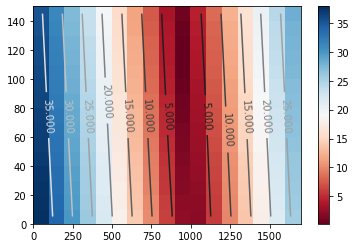

In [5]:
# VISUALIZING IT MORE WITH GRADIENT

#from matplotlib import cm
#from colorspacious import cspace_converter

def magpartial_func(addx, addy):
    partialx = -(b+a*mu)/(R*a**2*(sigma-mu**2))*(a*(addx-mu)+b+a*addx-addy)-1/R
    partialy = (b+a*mu)/(R*a**2*(sigma-mu**2))*(addx-mu)-1/(R*a)
    magpartial = math.sqrt(partialx**2+partialy**2)
    #print(magpartial)
    return magpartial

x = np.arange(0, 1750, 100)
y = np.arange(0, 160, 10)
#x = np.arange(-3.0, 3.0, 0.1)
#y = np.arange(-3.0, 3.0, 0.1)

x_center = 0.5 * (x[:-1] + x[1:])
y_center = 0.5 * (y[:-1] + y[1:])

X, Y = np.meshgrid(x_center, y_center)
Z = np.vectorize(magpartial_func)(X, Y)

# pcolormesh needs the pixel edges for x and y
# and with default flat shading, Z needs to be evaluated at the pixel center
plot = plt.pcolormesh(x, y, Z, cmap='RdBu', shading='flat')

# contour needs the centers
cset = plt.contour(X, Y, Z, cmap='gray')
plt.clabel(cset, inline=True)

plt.colorbar(plot)

This seems like a logical result: the lowest values center around where the line is (since if you add a point that is actually on the fit line, there should be no change). This also has no max/sup, as the further away points get the higher the magnitude of the gradient is. In particular, I was surprised to see the change was about equal along the strips of one color, since I thought being perpendicular to the line would cause the greatest change. I suppose really only distance matters in the macro scale (but when you add a constraint on distance, as in my Biggio test of adversarial attacks on cycle breaking SVM, perpendicularity becomes important).

Further work can be made where "common-sense" restrictions are added:
- common sense says cars must be between the two before and after them
- knowledge says lines must be decreasing (very negative slope)
- sum of x and y coordinates
    leading: x1, y1
    target: x2, y2
    should have x1+y1<x2+y2
- if know cycle start, end, data point should be within that cycle
- in pure (non real world) scenarios, minimizing the effort of perturbation, or how much you move the points

# Jagielski work and Gradient Descent Poisoning Attack

We test on an adversarial attack on SVM using a gradient-based maximum-confidence algorithm proposed by [Biggio](https://arxiv.org/abs/1708.06131), [Melis](https://arxiv.org/abs/1708.06939), [Demontis](https://www.usenix.org/conference/usenixsecurity19/presentation/demontis) et al. and [outlined](https://github.com/jagielski/manip-ml) in *Manipulating Machine Learning: Poisoning Attacks and Countermeasures for Regression Learning* by M. Jagielski.
The SVM in question is precisely our cycle breaking linear svm, with the data altered accordingly.

Dataset X: 
CArray([[ 6 -4]
 [ 4 -2]
 [ 4 -1]
 ...
 [ 3 -1]
 [ 5  1]
 [ 3 29]])
Dataset Y: 
CArray([0 0 0 ... 0 0 1])

CDataset{'X': CArray(100, 2)(dense: [[ 3  0] [ 3 -1] [ 9 -6] ... [ 9 67] [ 1  2] [ 2 -1]]), 'Y': CArray(100,)(dense: [0 0 0 ... 1 0 0]), 'header': None}
CDataset{'X': CArray(39, 2)(dense: [[ 20 -17] [  4  -2] [  1   1] ... [  2   0] [ 12 -11] [  7  68]]), 'Y': CArray(39,)(dense: [0 0 0 ... 0 0 1]), 'header': None}
Estimating the best training parameters...
The best training parameters are:  [('C', 100000)]
Accuracy on test set: 100.00%
Original x0 label:  0
Adversarial example label (PGD-LS):  1
Number of classifier gradient evaluations: 7
Original x0 label:  0
Adversarial example label (PGD):  1
Number of classifier gradient evaluations: 2


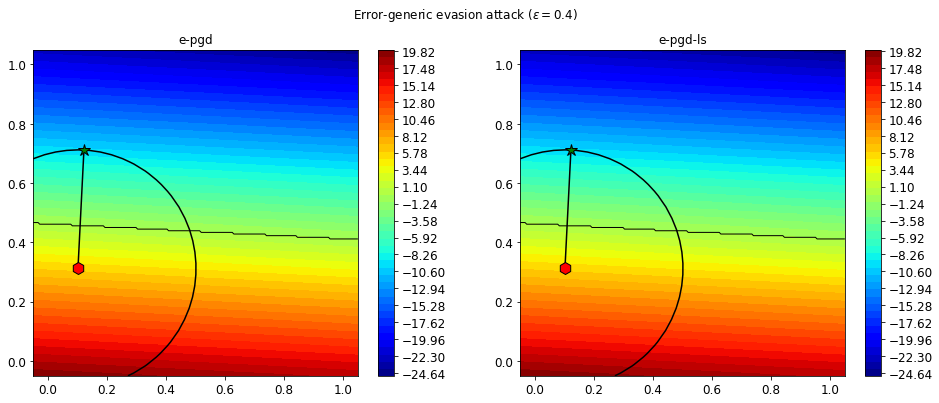

We can see that the initial point  x0(red hexagon) has been perturbed in the feature space so that is actually classified by the SVM as a point  from another class. The final adversarial example is the green star. We also show the l2 constraint as a black circle which has limited the maximum perturbation applicable to x0.
Notice how the line between  x0  and the green star looks perpendicular to the classifying line. This illustrates intuitively what the maximum effect of a perturbation is.
Running security evaluation...


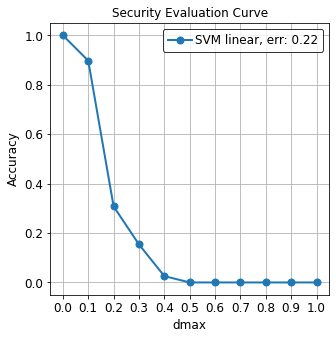

We can see how the SVM classifier is  vulnerable  to adversarial attacks and we are able to evade it even with small perturbations (indeed, when dmax is 0.5 the accuracy is basically zero!)


In [13]:
%run "/Users/geneyang/Documents/Arterial Travel Time/Attack,Evasion on CBV SVM.ipynb"